In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import random
from helper_functions import *

In [2]:
#VARIABLE PARAMETERS (4/29)

# Define Functions

In [3]:
def calc_s0(psi_init, h, m, g, mu, k, x_max, x_min, steps,x_vec,temp,potential):
    
    #normalize psi_init
    dx=(x_max-x_min)/steps
    psi_init=psi_init/np.sqrt(np.sum(np.abs(psi_init)**2)*dx)

    beta=1/k*temp

    #laplacian
    laps=[]
    for i in range(1,len(psi_init)-1):
        laplacian=-h**2/(2*m)*(psi_init[i+1]-2*psi_init[i]+psi_init[i-1])*psi_init[i]/((x_max-x_min)/steps)**2
        laps.append(laplacian.copy())
    laps_term=laps*np.conjugate(psi_init[1:-1])
    laps_int=integrate.simpson(laps_term, x=x_vec[1:-1])
    print("Laplacian Term: ", laps_int)

    #Potential term
    potential_term=potential*np.conjugate(psi_init)*psi_init
    potential_integrate=integrate.simpson(potential_term, x=x_vec)
    print("Potential Term: ", potential_integrate)

    #Norm^4
    norm4=(np.conjugate(psi_init)*psi_init)**2
    #print(norm4)
    norm4_term=integrate.simpson(norm4, x=x_vec)
    print("Norm^4 Term: ", norm4_term)

    #Norm^2 (part of number operation)
    norm2=np.conjugate(psi_init)*psi_init #I feel like this needs to explicitly be something times complex conj...
    norm2_term=integrate.simpson(norm2, x=x_vec)
    print("Norm^2 Term: ", norm2_term)
    print(type(norm2_term))

    S_0=-beta*((laps_int+potential_integrate+(g/2)*norm4_term)-mu*norm2_term)

    return S_0

In [4]:
def check_func(s0_final, s0_init, psi_new,psi_old,x_max, x_min, steps):

    dx=(x_max-x_min)/steps
    a=np.exp(s0_final-s0_init)
    print("value of a is: ", a)

    if a>=1:
        pass
        print("Candidate state is more probable than seeding state. Candidate state accepted.")
        accepted_s=s0_final
        psi_out=psi_new
    if a<1:
        rand=random.random() #generate random number between 0,1
        print("rand value is: ",rand)
        if rand<=a:
        #if rand >=.5:
            psi_out=psi_new
            print("From random number generation, candidate state is accepted.")
            accepted_s=s0_final
        else:
            pass
            print("From random number generation, candidate state is rejected.")
            accepted_s=s0_init
            psi_out=psi_old

    #normalize psi_out
    # psi_out_norm=psi_out/np.sqrt(np.sum(np.abs(psi_out)**2)*dx)
    
    return accepted_s, psi_out

In [5]:
def normalize(wave_function, x_start, x_end, num_steps):
    """
    Normalize the wave function.
        Parameters: 
            - Wave Function: array
            - x_start
            - x_end
            - dx
            - num steps
    """
    dx = (x_end-x_start)/num_steps
    psi_normalized = wave_function/np.sqrt(np.sum(np.abs(wave_function)**2)*dx)
    return psi_normalized

In [6]:
def loop_stochastic(h, m, g, k, mu, c1, c2, c3, v, phi, u, x_max, x_min, nsteps, xgrid, initial_wave_func, potential_func, iterations, temp):

    #Define initial and boundary conditions
    iter=0
    entropy_store=[]
    psi_store=[]
    psi_sq_store=[]
    psi_store.append(initial_wave_func.copy())

    while iter<iterations:

        print("Iteration: ", iter)

        #calculate inital entropy
        s0_init=calc_s0(initial_wave_func, h, m, g, mu, k, x_max, x_min, nsteps,xgrid, temp, potential_func)
        print("Initial reduced entropy: ",s0_init)

        # PERTURBATION
        rand=random.choice([0,1])

        if rand==0:
            #print("Generating density perturbation...")
            psi=initial_wave_func*(1+c1*v*np.sin(k*xgrid+phi))
        if rand==1:
            psi=initial_wave_func
        #     #print("Generating phase perturbation...")
        #     psi=initial_wave_func*np.exp((1j*c2*v*np.sin(k*xgrid+phi)))

        # Vary particle number
        psi=(1+c3*u)*psi
        #print("new psi is:",psi)

        # Calculate reduced energy of perturbed field
        s0_final=calc_s0(psi, h, m, g, mu, k, x_max, x_min, nsteps,xgrid, temp, potential_func)
        print("Final reduced entropy: ", s0_final)

        # Accept or reject perturbation
        accepted_s, initial_wave_func=check_func(s0_final, s0_init, psi, initial_wave_func, x_max, x_min, nsteps)
        entropy_store.append(accepted_s)
        psi_store.append(initial_wave_func)

        initial_wave_func = normalize(initial_wave_func, x_min, x_max, nsteps)
        
        psi_sq=np.conjugate(initial_wave_func)*initial_wave_func
        
        psi_sq = normalize(psi_sq, x_min, x_max, nsteps)
        psi_sq_store.append(psi_sq.copy())
        
        iter+=1
    return psi_store, psi_sq_store, entropy_store

# Run Code

In [7]:
#Define Constants
omega=1
hbar=1
mass=1
g_param=-1
k_boltz=1
mu_chem_potential=1
#N_iterations=10
c1_val=1
c2_val=1
c3_val=.001
v_val=1
phase=1
u=1

#Construct grid
x_start=-5
x_end=5
num_steps=1000
grid=np.linspace(x_start,x_end, num_steps)

#Construct potential and initial wave function
psi_0=(1/np.pi**.25)*np.exp(-.5*grid**2)
V=grid**2/2

#Define run parameters
iterations=1000
temperature=10

In [8]:
psi_array, psi_sq_array, entropy_array=loop_stochastic(hbar, mass, g_param, k_boltz, mu_chem_potential, c1_val, c2_val, c3_val, v_val, phase, u, x_end, x_start, num_steps, grid, psi_0, V, iterations, temperature)
psi_array2, psi_sq_array2, entropy_array2=loop_stochastic(hbar, mass, g_param, k_boltz, mu_chem_potential, c1_val, c2_val, c3_val, v_val, phase, u, x_end, x_start, num_steps, grid, psi_0, V, iterations, 20)

Iteration:  0
Laplacian Term:  0.20514417322280482
Potential Term:  0.2502502502306227
Norm^4 Term:  0.39974136338801036
Norm^2 Term:  1.0010010010009238
<class 'numpy.float64'>
Initial reduced entropy:  7.454772592415015
Laplacian Term:  0.356061686724362
Potential Term:  0.18017950065856503
Norm^4 Term:  0.49870083688531164
Norm^2 Term:  1.0010010010009522
<class 'numpy.float64'>
Final reduced entropy:  7.1411023206068105
value of a is:  0.73075994059328
rand value is:  0.2420992391514729
From random number generation, candidate state is accepted.
Iteration:  1
Laplacian Term:  0.356061686724362
Potential Term:  0.18017950065856503
Norm^4 Term:  0.49870083688531164
Norm^2 Term:  1.0010010010009522
<class 'numpy.float64'>
Initial reduced entropy:  7.1411023206068105
Laplacian Term:  0.5091996037798545
Potential Term:  0.16351288258077745
Norm^4 Term:  0.5754286426628642
Norm^2 Term:  1.001001001000961
<class 'numpy.float64'>
Final reduced entropy:  6.160028359717611
value of a is:  0.

# Plotting

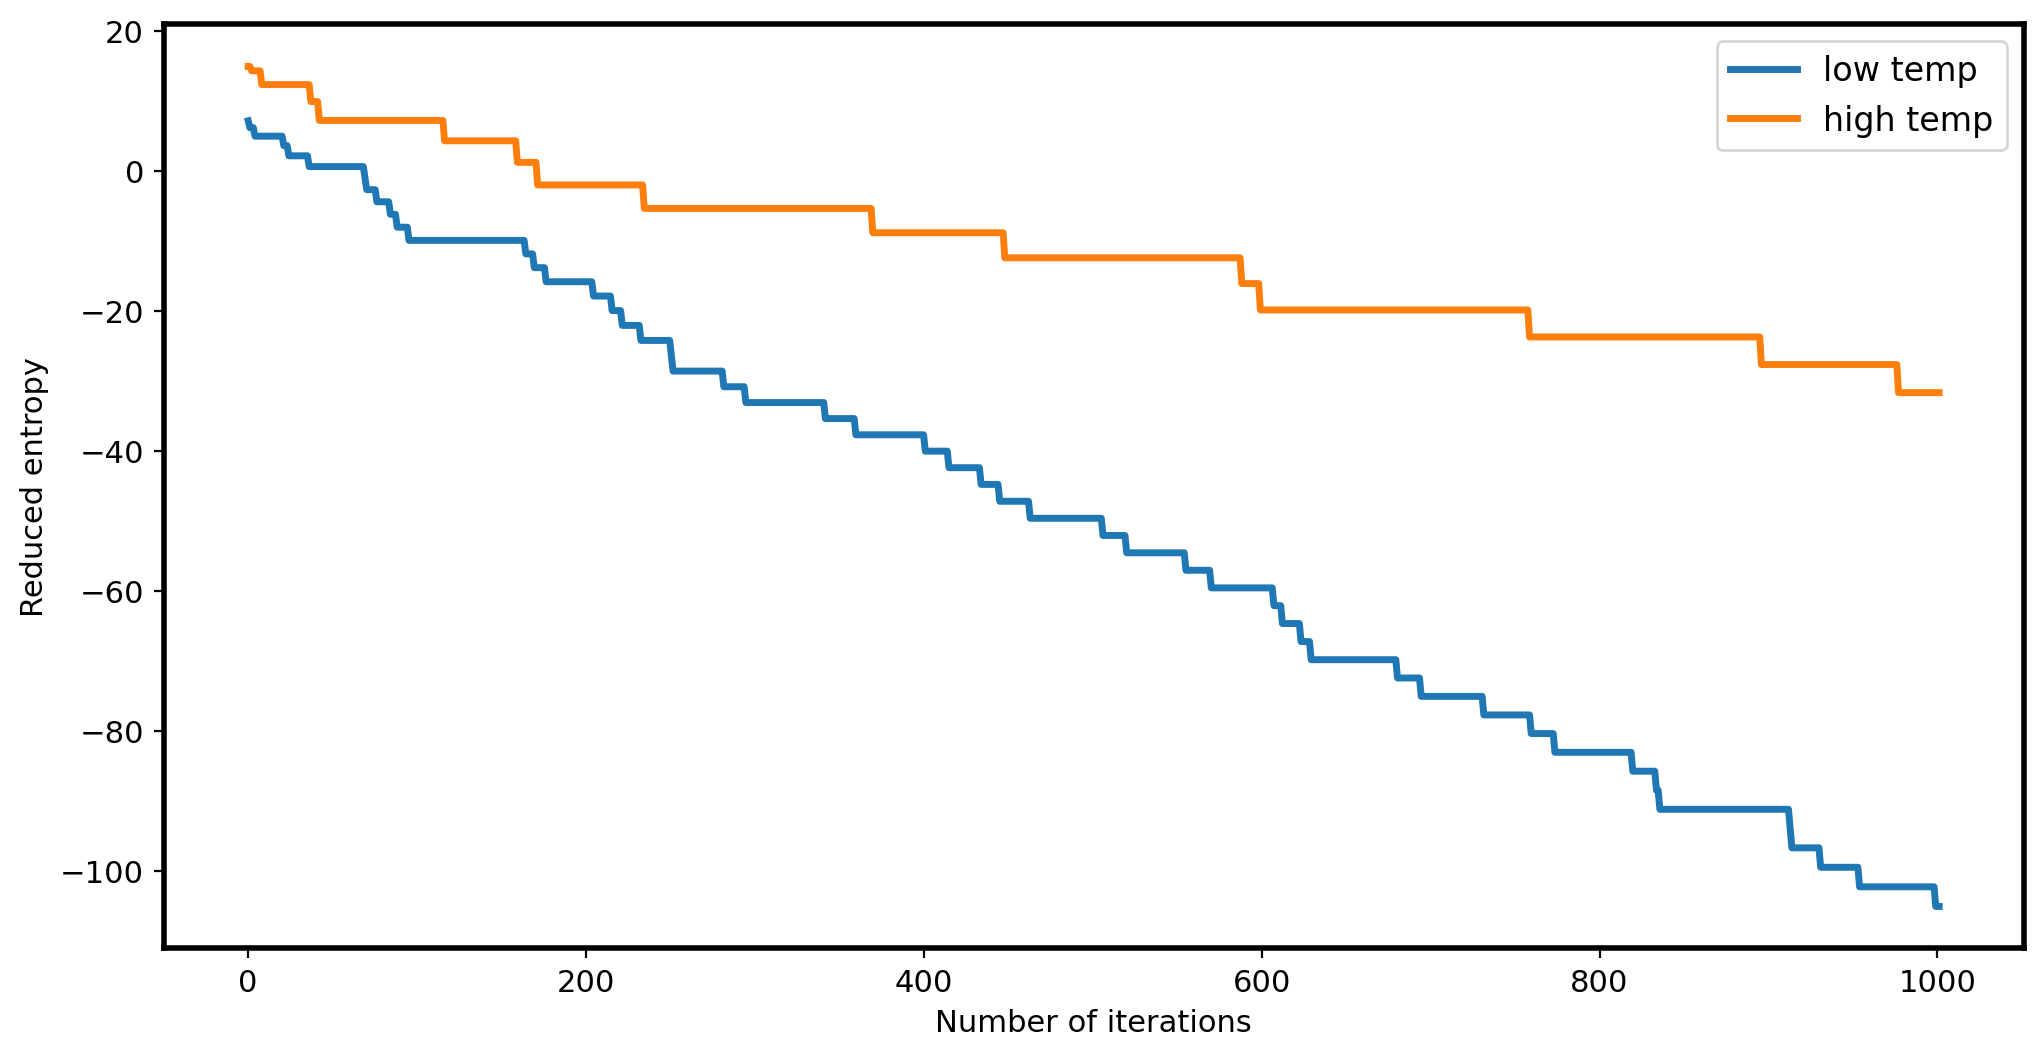

In [9]:
#Plot Reduced Entropy
fig=plt.figure()
plt.plot(np.linspace(0,iterations+1,iterations), np.real(entropy_array), label="low temp")
plt.plot(np.linspace(0,iterations+1,iterations), np.real(entropy_array2), label="high temp")
plt.xlabel("Number of iterations")
plt.ylabel("Reduced entropy")
plt.legend()
#plt.xlim(0,20)
plt.show()

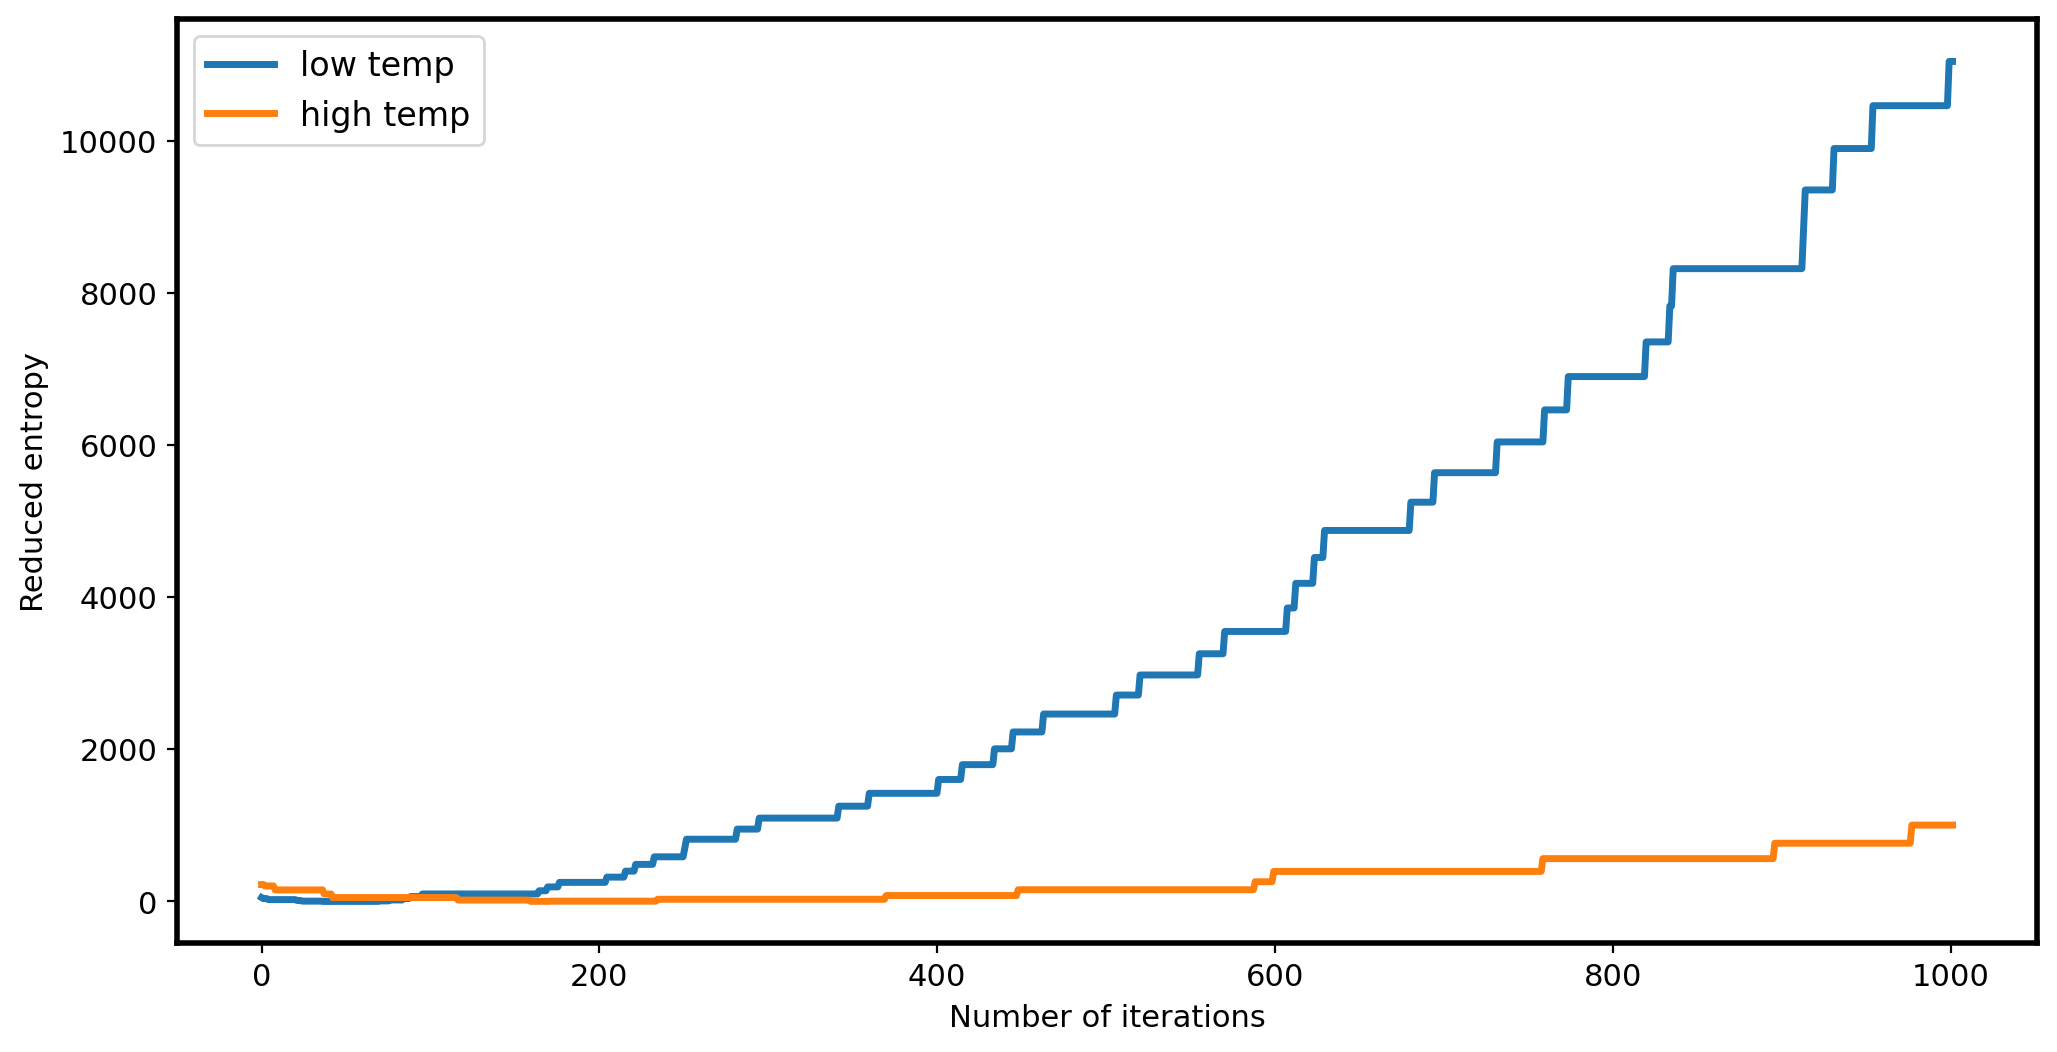

In [10]:
#Plot Reduced Entropy^2
fig=plt.figure()
plt.plot(np.linspace(0,iterations+1,iterations), np.abs(entropy_array)**2, label="low temp")
plt.plot(np.linspace(0,iterations+1,iterations), np.abs(entropy_array2)**2, label="high temp")
plt.xlabel("Number of iterations")
plt.ylabel("Reduced entropy")
plt.legend()
#plt.xlim(0,20)
plt.show()

In [11]:
# Plot Psi
# plt.figure()
# for i in range(0,len(psi_array)):
#     if i % iterations/100 == 0:
#         plt.plot(grid, np.real(psi_array[i]), label=i)
# plt.xlabel("Position")
# plt.ylabel("Psi")
# plt.legend()
# plt.show()


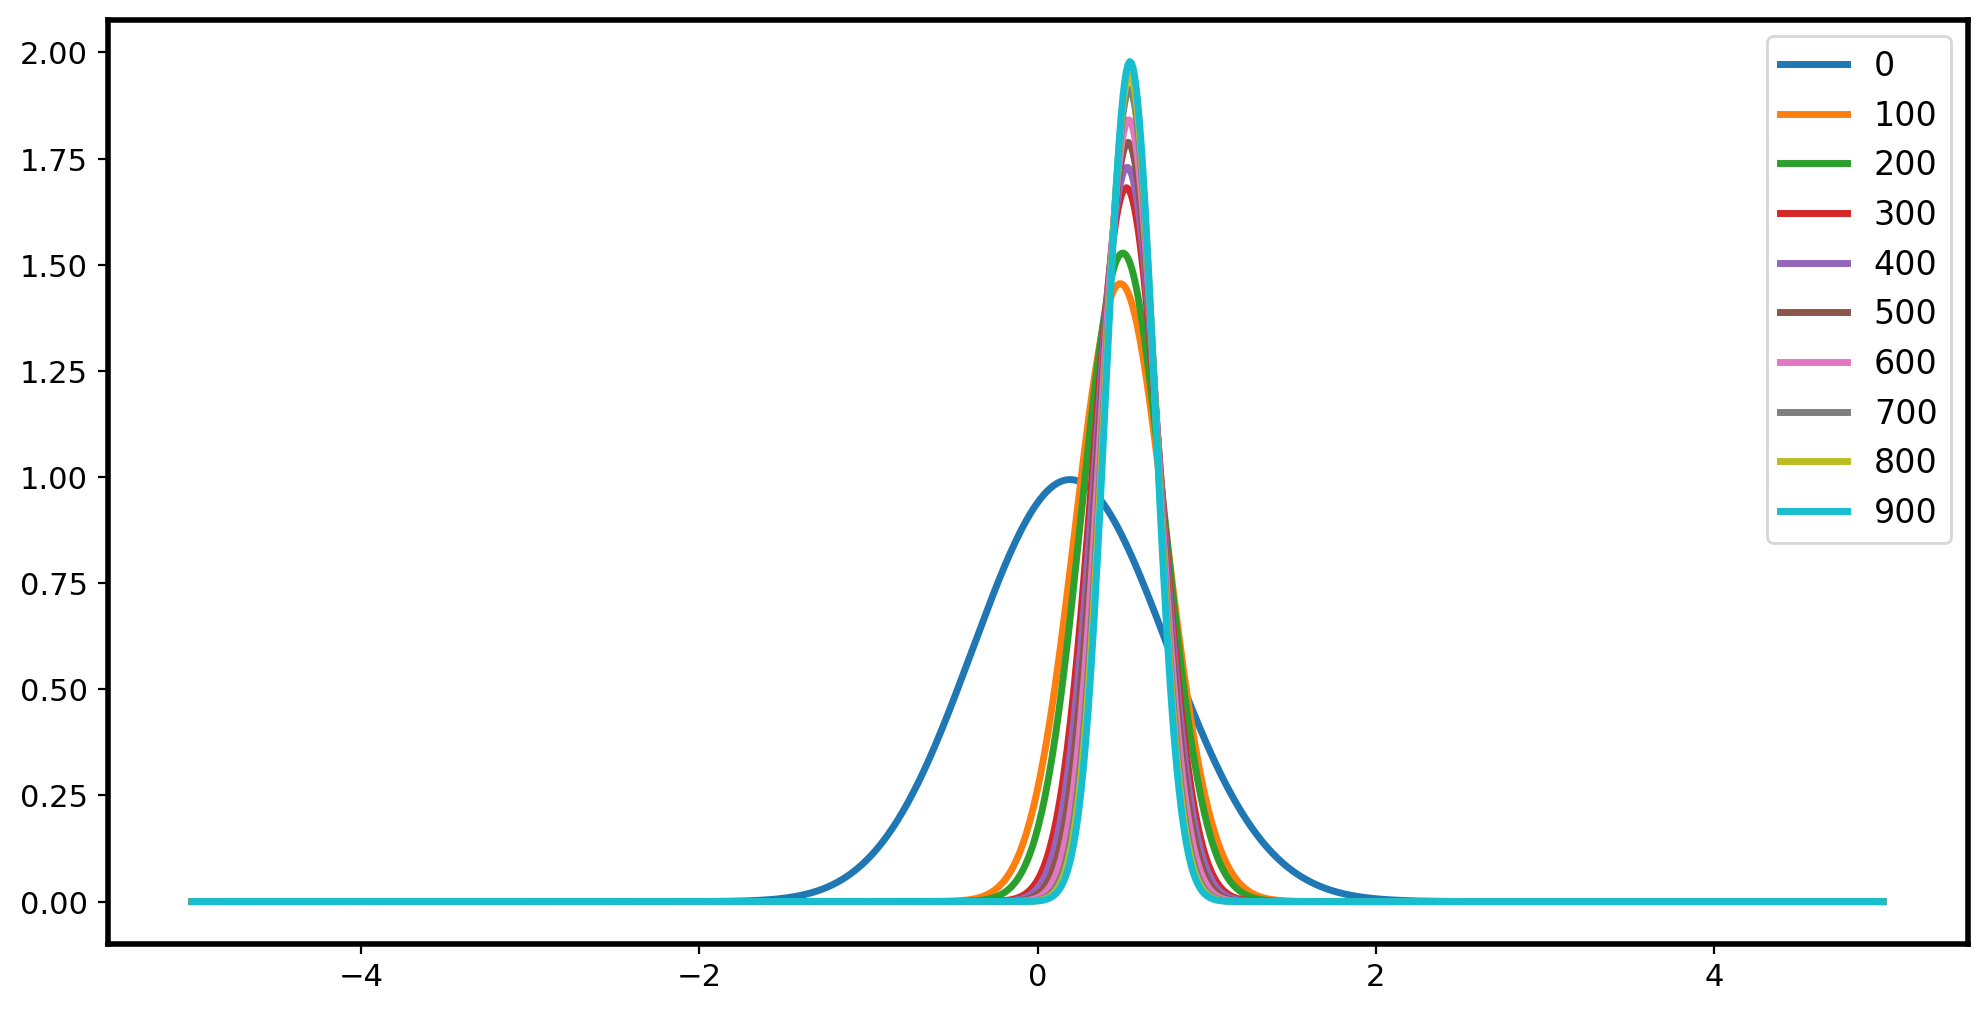

In [12]:
# Plot psi^2 (number density)
# iterations=1000
plt.figure()
for i in range(iterations):
    if i % 100 == 0:
        plt.plot(grid,psi_sq_array[i], label=i)
plt.legend()
plt.show()

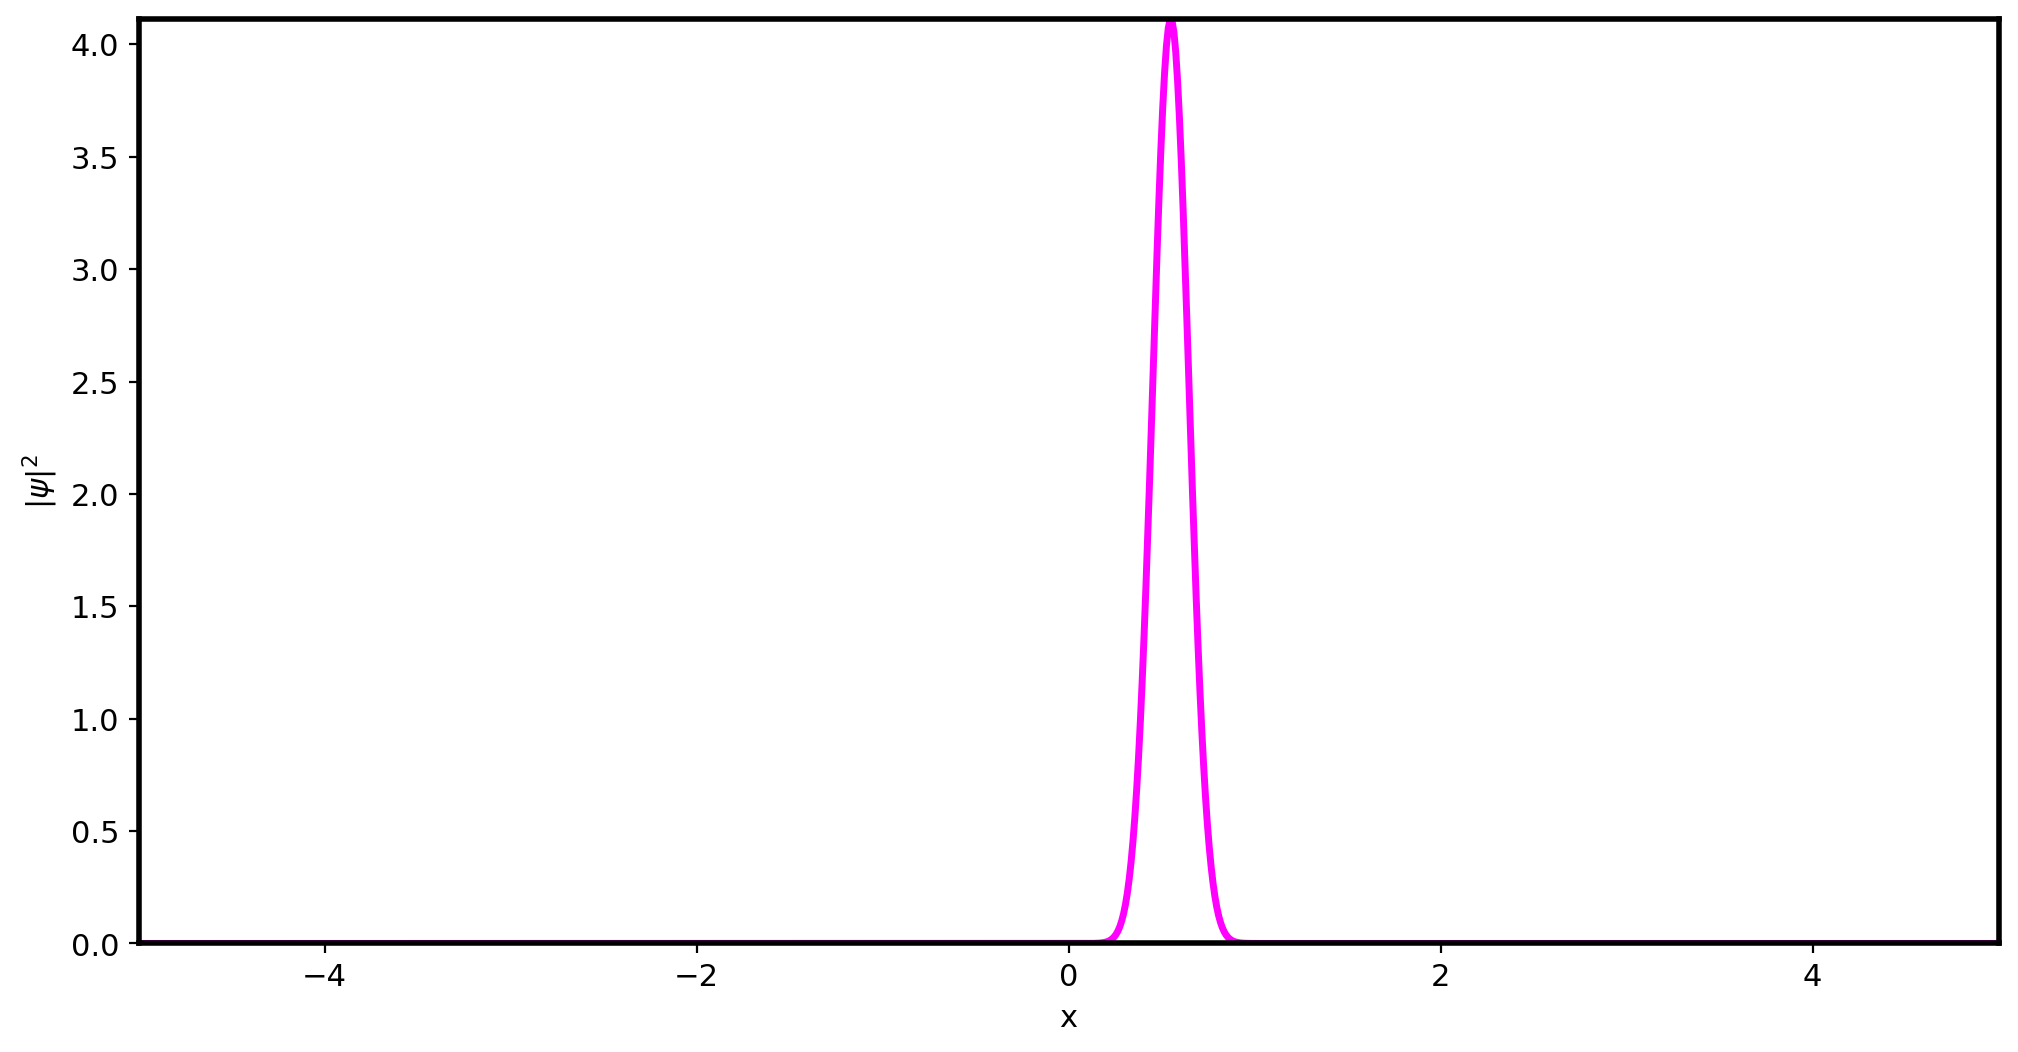

In [13]:
fname = "Test"
label= r"$|\psi|^2$"
steps = iterations
time_series = generate_time_series_psi_squared(grid, psi_sq_array, steps)
animate_psi(time_series, steps, fname, label, "magenta")

In [14]:
less = 0
excess = 0
for i in range(iterations):
    if i % 100 == 0:
        print("Iteratrion: ", i) 
        print(integrate.simpson(psi_sq_array[i],grid))

Iteratrion:  0
1.4181811845270547
Iteratrion:  100
0.9706956852782341
Iteratrion:  200
0.9252114225340825
Iteratrion:  300
0.8408779133272999
Iteratrion:  400
0.8175471586842088
Iteratrion:  500
0.7908664994452343
Iteratrion:  600
0.7680404171620222
Iteratrion:  700
0.7391397734368963
Iteratrion:  800
0.726553387525105
Iteratrion:  900
0.714970602076457
